## EIA Boiler Generator Associations Exploration

In our path towards compiling the marginal cost of electricity of all of the publicly reported generating units across the country, we wanted to compile the heat rate for each generating unit. The heat rate is important because it helps us attribute the fuel costs (which are reported at the plant level) to the actual electric generation (reported at the generator level). The heat rate is what links the fuel consumption (at the boiler) to the electricity generated (at the generator). This illuminated a hole in EIA’s 860 reported boiler generator associations, that we were able to compensate for through a series of matching cartwheels and network analysis.

We were previously doing all of this after the original data was ingested into the database, but we’ve recently reconfigured our database ingest process to move the new and improved boiler generator associations into its own table in PUDL.

### Boiler, schmoiler?

There are two essential elements of generating units - namely boilers and generators. You can think of them as the place where the fuel is burned (the boiler) and the place where the electricity is generated (the generator). Yes, this is a ridiculous simplification of a complex system but it will do for our purposes. In order to understand anything interesting about a generating unit, we need to connect the stuff being burned to the electricity created.

Combined-cycle gas plants. You can think of combined-cycle gas plants as having two.. well cycles. The first cycle is a gas turbine - gas goes in turns a turbine and hot air comes out. The second cycle takes that hot air, plus water to make steam to turn a steam turbine. In the first cycle, the gas turbine is the boiler as well as the generator.
State of the EIA Union

I can’t tell you how excited I was to find the 860 environmental associations table with boiler generator associations. And subsequently I can’t tell you how confused I got upon realizing that the associations were complete for some plants but not others. So we reached out the EIA to get a handle on what was happening.

“As I am sure you are aware, we account for combined cycle facilities using three prime mover codes:
- CA – combined cycle steam part
- CS – combined cycle single shaft
- CT – combined cycle turbine part
For our EIA-860 and EIA-923 reports, plants are only supposed to submit data on their boilers and associated equipment. Therefore, since boilers are associated with steam generators, only the generators that have a prime mover of a “CA” or “CS” (when referring to combined cycle facilities) are listed in the boiler/generator association table. The gas turbine parts of combined cycle facilities (prime mover “CT”) are not included in this association table.”

Well that’s explainable enough, although not particularly useful. This means that all of the combustion turbines (remember - cycle 1 - that’s where are the natural gas is being burned) in all of the combined cycle plants across the country were not attached to the steam turbines. This was resulting in some very strange heat rates because all of the assigned generation was attached to the boilers with little to no fuel. 

### Imports & Set-up

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import pandas as pd
import numpy as np
import sqlalchemy as sa
import postgres_copy
import copy
import re
import networkx as nx

from pudl import init
from pudl import constants as pc
import pudl.extract.eia923
import pudl.extract.eia860
import pudl.transform.eia
import pudl.output.pudltabl
import pudl.helpers
import warnings
warnings.filterwarnings('ignore')

In [2]:
eia923_tables=pc.eia923_pudl_tables
eia923_years=pc.working_years['eia923']
eia860_tables=pc.eia860_pudl_tables
eia860_years=pc.working_years['eia860']
verbose=False
debug=False

In [3]:
eia923_raw_dfs = pudl.extract.eia923.extract(eia923_years=eia923_years,
                                verbose=verbose)

eia860_raw_dfs = pudl.extract.eia860.extract(eia860_years=eia860_years,
                                verbose=verbose)
eia923_transformed_dfs = \
    pudl.transform.eia923.transform(eia923_raw_dfs,
                                    eia923_tables=eia923_tables,
                                    verbose=verbose)

eia860_transformed_dfs = \
    pudl.transform.eia860.transform(eia860_raw_dfs,
                                    eia860_tables=eia860_tables,
                                    verbose=verbose)

eia_transformed_dfs = copy.deepcopy(eia860_transformed_dfs)
eia_transformed_dfs.update(copy.deepcopy(eia923_transformed_dfs))

### Building Blocks

We’ve been mainly working with two separate EIA forms: 923 and 860. In order to compile the more complete boiler generator associations, we compiled all of the table from 860 and 923 which have boilers or generators to try to connect as many of them as possible. Here are the tables which are different tabs in 923’s reporting and different files in 860 (with the original EIA table name and the PUDL table name):

923 Tables:
- Generator / ‘generation_eia923’: monthly net generation by generator
- Boiler Fuel / ‘boiler_fuel_eia923’: monthly fuel consumption (in number of physical units and MMBTU per unit) by boiler
        
860 Tables:
- Enviro_Assoc / ‘boiler_generator_assn_eia860’ - the (limited) boiler generator associations
- Generator / ‘generators_eia860’: generator info, including capacity and (limited) unit codes

In [4]:
# compile and scrub all the parts
bga_eia860 = eia_transformed_dfs['boiler_generator_assn_eia860'].copy()
bga_eia860 = pudl.transform.eia._restrict_years(bga_eia860, eia923_years, eia860_years)
bga_eia860['generator_id'] = bga_eia860.generator_id.astype(str)
bga_eia860['boiler_id'] = bga_eia860.boiler_id.astype(str)
bga_eia860 = bga_eia860.drop(['operator_id'], axis=1)

gen_eia923 = eia_transformed_dfs['generation_eia923'].copy()
gen_eia923 = pudl.transform.eia._restrict_years(gen_eia923, eia923_years, eia860_years)
gen_eia923['generator_id'] = gen_eia923.generator_id.astype(str)
gen_eia923 = gen_eia923.set_index(pd.DatetimeIndex(gen_eia923.report_date))

gen_eia923_gb = gen_eia923.groupby(
    [pd.Grouper(freq='AS'), 'plant_id_eia', 'generator_id'])
gen_eia923 = gen_eia923_gb['net_generation_mwh'].sum().reset_index()
gen_eia923['missing_from_923'] = False

# The generator records that are missing from 860 but appear in 923
# I created issue no. 128 to deal with this at a later date
merged = pd.merge(eia_transformed_dfs['generators_eia860'].copy(),
                  gen_eia923,
                  on=['plant_id_eia', 'report_date', 'generator_id'],
                  indicator=True, how='outer')
missing = merged[merged['_merge'] == 'right_only']

# compile all of the generators
gens_eia860 = eia_transformed_dfs['generators_eia860'].copy()
gens_eia860 = pudl.transform.eia._restrict_years(gens_eia860, eia923_years, eia860_years)
gens_eia860['generator_id'] = gens_eia860.generator_id.astype(str)
gens = pd.merge(gen_eia923, gens_eia860,
                on=['plant_id_eia', 'report_date', 'generator_id'],
                how='outer')

gens = gens[['plant_id_eia',
             'report_date',
             'generator_id',
             'unit_code',
             'net_generation_mwh',
             'missing_from_923']].drop_duplicates()

gens['generator_id'] = gens['generator_id'].astype(str)

We’re going to use Barry (yes, that is the plant that is basically always at the top of every table) because it’s a relatively good example.

In [5]:
stage = bga_eia860
stage[(stage['plant_id_eia'] == 3) & (stage['report_date'].dt.year == 2015)]

,plant_id_eia,boiler_id,generator_id,report_date
0,3,1,1,2015-01-01
1,3,2,2,2015-01-01
2,3,3,3,2015-01-01
3,3,4,4,2015-01-01
4,3,5,5,2015-01-01
5,3,6A,A1ST,2015-01-01
6,3,6B,A1ST,2015-01-01
7,3,7B,A2ST,2015-01-01
8,3,7A,A2ST,2015-01-01


In [6]:
stage = gens
stage[(stage['plant_id_eia'] == 3) & (stage['report_date'].dt.year == 2015)]

,plant_id_eia,report_date,generator_id,unit_code,net_generation_mwh,missing_from_923
13914,3,2015-01-01,1,NaN,-1413.0,False
13915,3,2015-01-01,2,NaN,418.0,False
13916,3,2015-01-01,3,NaN,92406.0,False
13917,3,2015-01-01,4,NaN,1577172.0,False
13918,3,2015-01-01,5,NaN,2935726.0,False
13919,3,2015-01-01,A1CT,G521,1096926.0,False
13920,3,2015-01-01,A1CT2,G521,1129228.0,False
13921,3,2015-01-01,A1ST,G521,1269176.0,False
13922,3,2015-01-01,A2C1,G522,1025123.0,False
13923,3,2015-01-01,A2C2,G522,1067440.0,False


### Use what yo mamma gave you..

First we compiled a complete list of generators from 923 and 860. Then we merged the 860 boiler generator associations onto that list. The generators with associated boilers were all labeled with an “eia860_org” tag indicating it came from the original EIA 860 reporting.

In [7]:
# create the beginning of a bga compilation w/ the generators as the
# background
bga_compiled_1 = pd.merge(gens, bga_eia860,
                          on=['plant_id_eia', 'generator_id',
                              'report_date'],
                          how='outer')

# Create a set of bga's that are linked, directly from bga8
bga_assn = bga_compiled_1[bga_compiled_1['boiler_id'].notnull()].copy()
bga_assn['bga_source'] = 'eia860_org'

# Create a set of bga's that were not linked directly through bga8
bga_unassn = bga_compiled_1[bga_compiled_1['boiler_id'].isnull()].copy()
bga_unassn = bga_unassn.drop(['boiler_id'], axis=1)


In [8]:
stage = bga_compiled_1
stage[(stage['plant_id_eia'] == 3) & (stage['report_date'].dt.year == 2015)]

,plant_id_eia,report_date,generator_id,unit_code,net_generation_mwh,missing_from_923,boiler_id
25912,3,2015-01-01,1,NaN,-1413.0,False,1
25913,3,2015-01-01,2,NaN,418.0,False,2
25914,3,2015-01-01,3,NaN,92406.0,False,3
25915,3,2015-01-01,4,NaN,1577172.0,False,4
25916,3,2015-01-01,5,NaN,2935726.0,False,5
25917,3,2015-01-01,A1CT,G521,1096926.0,False,NaN
25918,3,2015-01-01,A1CT2,G521,1129228.0,False,NaN
25919,3,2015-01-01,A1ST,G521,1269176.0,False,6A
25920,3,2015-01-01,A1ST,G521,1269176.0,False,6B
25921,3,2015-01-01,A2C1,G522,1025123.0,False,NaN


That got us 57% of the annual boiler/generator mappings but then we had to compile the rest.

### String Matching

We realized in our sleuthing that many of unmapped boilers and generators id’s actually are the same strings - which is weird because most of the id’s mapped in the 860 association table have wildly different id’s. But alas, we simply merged the remaining unmapped generators to the unmapped boilers with the report date, EIA plant id, and the respective boiler or generator id. This mapped another 3,621 records - another 2% of the mappings!

In [9]:
bf_eia923 = eia_transformed_dfs['boiler_fuel_eia923'].copy()
bf_eia923 = pudl.transform.eia._restrict_years(bf_eia923, eia923_years, eia860_years)
bf_eia923['boiler_id'] = bf_eia923.boiler_id.astype(str)
bf_eia923['total_heat_content_mmbtu'] = bf_eia923['fuel_qty_consumed'] * \
    bf_eia923['fuel_mmbtu_per_unit']
bf_eia923 = bf_eia923.set_index(pd.DatetimeIndex(bf_eia923.report_date))
bf_eia923_gb = bf_eia923.groupby(
    [pd.Grouper(freq='AS'), 'plant_id_eia', 'boiler_id'])
bf_eia923 = bf_eia923_gb.agg({
    'total_heat_content_mmbtu': pudl.helpers.sum_na,
}).reset_index()

bf_eia923.drop_duplicates(
    subset=['plant_id_eia', 'report_date', 'boiler_id'], inplace=True)

# Create a list of boilers that were not in bga8
bf9_bga = bf_eia923.merge(bga_compiled_1,
                          on=['plant_id_eia', 'boiler_id', 'report_date'],
                          how='outer',
                          indicator=True)
bf9_not_in_bga = bf9_bga[bf9_bga['_merge'] == 'left_only']
bf9_not_in_bga = bf9_not_in_bga.drop(['_merge'], axis=1)

# Match the unassociated generators with unassociated boilers
# This method is assuming that some the strings of the generators and the
# boilers are the same
bga_unassn = bga_unassn.merge(bf9_not_in_bga[['plant_id_eia',
                                              'boiler_id',
                                              'report_date']],
                              how='left',
                              left_on=['report_date',
                                       'plant_id_eia',
                                       'generator_id'],
                              right_on=['report_date',
                                        'plant_id_eia',
                                        'boiler_id'])
bga_unassn.sort_values(['report_date', 'plant_id_eia'], inplace=True)

bga_unassn['bga_source'] = None
bga_unassn.loc[bga_unassn.boiler_id.notnull(),
               'bga_source'] = 'string_assn'

bga_compiled_2 = bga_assn.append(bga_unassn)
bga_compiled_2.sort_values(['plant_id_eia', 'report_date'], inplace=True)
bga_compiled_2['missing_from_923'].fillna(value=True, inplace=True)

In [10]:
stage = bga_compiled_2
stage[(stage['plant_id_eia'] == 3) & (stage['report_date'].dt.year == 2015)]

,plant_id_eia,report_date,generator_id,unit_code,net_generation_mwh,missing_from_923,boiler_id,bga_source
25912,3,2015-01-01,1,NaN,-1413.0,False,1,eia860_org
25913,3,2015-01-01,2,NaN,418.0,False,2,eia860_org
25914,3,2015-01-01,3,NaN,92406.0,False,3,eia860_org
25915,3,2015-01-01,4,NaN,1577172.0,False,4,eia860_org
25916,3,2015-01-01,5,NaN,2935726.0,False,5,eia860_org
25919,3,2015-01-01,A1ST,G521,1269176.0,False,6A,eia860_org
25920,3,2015-01-01,A1ST,G521,1269176.0,False,6B,eia860_org
25923,3,2015-01-01,A2ST,G522,1195360.0,False,7B,eia860_org
25924,3,2015-01-01,A2ST,G522,1195360.0,False,7A,eia860_org
2137,3,2015-01-01,A1CT,G521,1096926.0,False,A1CT,string_assn


### Using the Unit Codes

The next step was to use the unit code reported in the EIA 860 generators table. These unit codes are not reported for every single generator record. There are 9592 records from 2011-2016 with some unit code. Largely, this helped connect the remaining, unmapped steam turbine portion of the combined-cycle plants to the natural gas turbine portion. All of a sudden we had 80% of the generators mapped.

In [11]:
# Connect the gens and boilers in units
bga_compiled_units = bga_compiled_2.loc[
    bga_compiled_2['unit_code'].notnull()]
bga_gen_units = bga_compiled_units.drop(['boiler_id'], axis=1)
bga_boil_units = bga_compiled_units[['plant_id_eia',
                                     'report_date',
                                     'boiler_id',
                                     'unit_code']].copy()
bga_boil_units.dropna(subset=['boiler_id'], inplace=True)

# merge the units with the boilers
bga_unit_compilation = bga_gen_units.merge(bga_boil_units,
                                           how='outer',
                                           on=['plant_id_eia',
                                               'report_date',
                                               'unit_code'],
                                           indicator=True)

# label the bga_source
bga_unit_compilation. \
    loc[bga_unit_compilation['bga_source'].isnull(),
        'bga_source'] = 'unit_connection'

bga_unit_compilation.drop(['_merge'], axis=1, inplace=True)
bga_non_units = bga_compiled_2[bga_compiled_2['unit_code'].isnull()]

# combine the unit compilation and the non units
bga_compiled_3 = bga_non_units.append(bga_unit_compilation)

# resort the records and the columns
bga_compiled_3.sort_values(['plant_id_eia', 'report_date'], inplace=True)
bga_compiled_3 = bga_compiled_3[['plant_id_eia',
                                 'report_date',
                                 'generator_id',
                                 'boiler_id',
                                 'unit_code',
                                 'bga_source',
                                 'net_generation_mwh',
                                 'missing_from_923']]

In [12]:
stage = bga_compiled_3
stage[(stage['plant_id_eia'] == 3) & (stage['report_date'].dt.year == 2015)]

,plant_id_eia,report_date,generator_id,boiler_id,unit_code,bga_source,net_generation_mwh,missing_from_923
25912,3,2015-01-01,1,1,NaN,eia860_org,-1413.0,False
25913,3,2015-01-01,2,2,NaN,eia860_org,418.0,False
25914,3,2015-01-01,3,3,NaN,eia860_org,92406.0,False
25915,3,2015-01-01,4,4,NaN,eia860_org,1577172.0,False
25916,3,2015-01-01,5,5,NaN,eia860_org,2935726.0,False
80,3,2015-01-01,A1ST,6A,G521,eia860_org,1269176.0,False
81,3,2015-01-01,A1ST,6B,G521,eia860_org,1269176.0,False
82,3,2015-01-01,A1ST,A1CT,G521,eia860_org,1269176.0,False
83,3,2015-01-01,A1ST,A1CT2,G521,eia860_org,1269176.0,False
84,3,2015-01-01,A1ST,6A,G521,eia860_org,1269176.0,False


This cell is largely for labeling plants and generators with helpful indicators.

In [13]:
# label plants that have 'bad' generator records (generators that have MWhs
# in gens9 but don't have connected boilers) create a df with just the bad
# plants by searching for the 'bad' generators
bad_plants = bga_compiled_3[(bga_compiled_3['boiler_id'].isnull()) &
                            (bga_compiled_3['net_generation_mwh'] > 0)].\
    drop_duplicates(subset=['plant_id_eia', 'report_date'])
bad_plants = bad_plants[['plant_id_eia', 'report_date']]

# merge the 'bad' plants back into the larger frame
bga_compiled_3 = bga_compiled_3.merge(bad_plants,
                                      how='outer',
                                      on=['plant_id_eia', 'report_date'],
                                      indicator=True)

# use the indicator to create labels
bga_compiled_3['plant_w_bad_generator'] = \
    np.where(bga_compiled_3._merge == 'both', True, False)
# Note: At least one gen has reported MWh in 923, but could not be
# programmatically mapped to a boiler

# we don't need this one anymore
bga_compiled_3 = bga_compiled_3.drop(['_merge'], axis=1)

# create a label for generators that are unmapped but in 923
bga_compiled_3['unmapped_but_in_923'] = \
    np.where((bga_compiled_3.boiler_id.isnull()) &
             ~bga_compiled_3.missing_from_923 &
             (bga_compiled_3.net_generation_mwh == 0),
             True,
             False)

# create a label for generators that are unmapped
bga_compiled_3['unmapped'] = np.where(bga_compiled_3.boiler_id.isnull(),
                                      True,
                                      False)
bga_out = bga_compiled_3.drop('net_generation_mwh', axis=1)
bga_out.loc[bga_out.unit_code.isnull(), 'unit_code'] = None

### Unit Mapping

The collection of boilers and generators that we really care about is the generating unit - i.e. every boiler and generator that is connected and interdependent. It doesn’t make sense to talk about a “heat rate” at any smaller unit, since the fuel consumption and electricity output are mingled at the unit level In order to connect the relatively disparate associated generators and boilers into units, we did some simple network analysis, using the NetworkX python package originally developed at the Los Alamos National Laboratory. For every plant, we created a graph of all of the connections between the boilers and generators, and every connected subgraph was assigned a unique unit id.

In [14]:
bga_for_nx = bga_out[['plant_id_eia', 'report_date', 'generator_id',
                      'boiler_id', 'unit_code']]
# If there's no boiler... there's no boiler-generator association
bga_for_nx = bga_for_nx.dropna(subset=['boiler_id']).drop_duplicates()

# Need boiler & generator specific ID strings, or they look like
# the same node to NX
bga_for_nx['generators'] = 'p' + bga_for_nx.plant_id_eia.astype(str) + \
                           '_g' + bga_for_nx.generator_id.astype(str)
bga_for_nx['boilers'] = 'p' + bga_for_nx.plant_id_eia.astype(str) + \
                        '_b' + bga_for_nx.boiler_id.astype(str)

# dataframe to accumulate the unit_ids in
bga_w_units = pd.DataFrame()
# We want to start our unit_id counter anew for each plant:
for pid in bga_for_nx.plant_id_eia.unique():
    bga_byplant = bga_for_nx[bga_for_nx.plant_id_eia == pid].copy()

    # Create a graph from the dataframe of boilers and generators. It's a
    # multi-graph, meaning the same nodes can be connected by more than one
    # edge -- this allows us to preserve multiple years worth of boiler
    # generator association information for later inspection if need be:
    bga_graph = nx.from_pandas_edgelist(bga_byplant,
                                        source='generators',
                                        target='boilers',
                                        edge_attr=True,
                                        create_using=nx.MultiGraph())

    # Each connected sub-graph is a generation unit:
    gen_units = list(nx.connected_component_subgraphs(bga_graph))

    # Assign a unit_id to each subgraph, and extract edges into a dataframe
    for unit_id, unit in zip(range(len(gen_units)), gen_units):
        # All the boiler-generator association graphs should be bi-partite,
        # meaning generators only connect to boilers, and boilers only
        # connect to generators.
        assert nx.algorithms.bipartite.is_bipartite(unit), \
            """Non-bipartite generation unit graph found.
plant_id_eia={}, unit_id_pudl={}.""".format(pid, unit_id)
        nx.set_edge_attributes(
            unit, name='unit_id_pudl', values=unit_id + 1)
        new_unit_df = nx.to_pandas_edgelist(unit)
        bga_w_units = bga_w_units.append(new_unit_df)
        
bga_w_units = bga_w_units.sort_values(['plant_id_eia', 'unit_id_pudl',
                                       'generator_id', 'boiler_id'])
bga_w_units = bga_w_units.drop(['source', 'target'], axis=1)

In [15]:
stage = bga_w_units
stage[(stage['plant_id_eia'] == 3) & (stage['report_date'].dt.year == 2015)]

,report_date,generator_id,unit_code,plant_id_eia,boiler_id,unit_id_pudl
4,2015-01-01,1,None,3,1,1
4,2015-01-01,2,None,3,2,2
4,2015-01-01,3,None,3,3,3
4,2015-01-01,4,None,3,4,4
4,2015-01-01,5,None,3,5,5
40,2015-01-01,A1CT,G521,3,6A,6
10,2015-01-01,A1CT,G521,3,6B,6
43,2015-01-01,A1CT,G521,3,A1CT,6
31,2015-01-01,A1CT,G521,3,A1CT2,6
25,2015-01-01,A1CT2,G521,3,6A,6


In [16]:
# Check whether the PUDL unit_id values we've inferred conflict with
# the unit_code values that were reported to EIA. Are there any PUDL
# unit_id values that have more than 1 EIA unit_code within them?
bga_unit_code_counts = \
    bga_w_units.groupby(['plant_id_eia', 'unit_id_pudl'])['unit_code'].\
    nunique().to_frame().reset_index()
bga_unit_code_counts = bga_unit_code_counts.rename(
    columns={'unit_code': 'unit_code_count'})
bga_unit_code_counts = pd.merge(bga_w_units, bga_unit_code_counts,
                                on=['plant_id_eia', 'unit_id_pudl'])
too_many_codes = \
    bga_unit_code_counts[bga_unit_code_counts.unit_code_count > 1]
too_many_codes = \
    too_many_codes[~too_many_codes.unit_code.isnull()].\
    groupby(['plant_id_eia', 'unit_id_pudl'])['unit_code'].unique()
print('WARNING: multiple EIA unit codes found in these PUDL units:')
print(too_many_codes)
bga_w_units = bga_w_units.drop('unit_code', axis=1)

# These assertions test that all boilers and generators ended up in the
# same unit_id across all the years of reporting:
assert (bga_w_units.groupby(
    ['plant_id_eia', 'generator_id'])['unit_id_pudl'].nunique() == 1).all()
assert (bga_w_units.groupby(
    ['plant_id_eia', 'boiler_id'])['unit_id_pudl'].nunique() == 1).all()
bga_w_units = bga_w_units.drop('report_date', axis=1)
bga_w_units = bga_w_units[['plant_id_eia', 'unit_id_pudl',
                           'generator_id', 'boiler_id']].drop_duplicates()
bga_out = pd.merge(bga_out, bga_w_units, how='left',
                   on=['plant_id_eia', 'generator_id', 'boiler_id'])
bga_out['unit_id_pudl'] = \
    bga_out['unit_id_pudl'].fillna(value=0).astype(int)

plant_id_eia  unit_id_pudl
1004          3                         [1, CT1]
1904          1                     [HBR0, BDS0]
1927          1                     [RIV0, HBR0]
4040          1                     [PWG1, PWG2]
10725         1                     [F801, F802]
50973         1               [BLK1, BLK2, BLK3]
55153         1                     [STG1, STG2]
55309         1                     [SMR1, SMR2]
55502         1                 [CC1, G801, CC2]
56041         1                       [NGS, MGS]
56350         1                      [BLK1, 115]
              2                      [BLK2, 116]
56998         1                        [43, PB4]
              2                        [53, PB5]
60786         1                     [4343, 4141]
Name: unit_code, dtype: object


In [17]:
statge = bga_out
stage[(stage['plant_id_eia'] == 3) & (stage['report_date'].dt.year == 2015)]

,report_date,generator_id,unit_code,plant_id_eia,boiler_id,unit_id_pudl
4,2015-01-01,1,None,3,1,1
4,2015-01-01,2,None,3,2,2
4,2015-01-01,3,None,3,3,3
4,2015-01-01,4,None,3,4,4
4,2015-01-01,5,None,3,5,5
40,2015-01-01,A1CT,G521,3,6A,6
10,2015-01-01,A1CT,G521,3,6B,6
43,2015-01-01,A1CT,G521,3,A1CT,6
31,2015-01-01,A1CT,G521,3,A1CT2,6
25,2015-01-01,A1CT2,G521,3,6A,6


In [18]:
if not debug:
    bga_out = bga_out[~bga_out.missing_from_923 &
                      ~bga_out.plant_w_bad_generator &
                      ~bga_out.unmapped_but_in_923 &
                      ~bga_out.unmapped]

    bga_out = bga_out.drop(['missing_from_923',
                            'plant_w_bad_generator',
                            'unmapped_but_in_923',
                            'unmapped'], axis=1)
    bga_out = bga_out.drop_duplicates(subset=['report_date',
                                              'plant_id_eia',
                                              'boiler_id',
                                              'generator_id'])


In [19]:
statge = bga_out
stage[(stage['plant_id_eia'] == 3) & (stage['report_date'].dt.year == 2015)]

,report_date,generator_id,unit_code,plant_id_eia,boiler_id,unit_id_pudl
4,2015-01-01,1,None,3,1,1
4,2015-01-01,2,None,3,2,2
4,2015-01-01,3,None,3,3,3
4,2015-01-01,4,None,3,4,4
4,2015-01-01,5,None,3,5,5
40,2015-01-01,A1CT,G521,3,6A,6
10,2015-01-01,A1CT,G521,3,6B,6
43,2015-01-01,A1CT,G521,3,A1CT,6
31,2015-01-01,A1CT,G521,3,A1CT2,6
25,2015-01-01,A1CT2,G521,3,6A,6


### Barry's Unit Network

This is an exploration of the network analysis so we can extract the
visualization of the mappings for Barry.

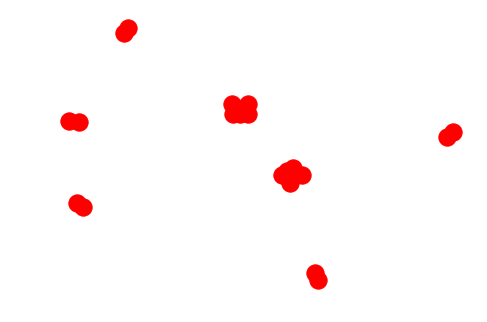

In [20]:
# For showing the network graph for Barry
bga_byplant = bga_for_nx[bga_for_nx.plant_id_eia == 3].copy()

# Create a graph from the dataframe of boilers and generators. It's a
# multi-graph, meaning the same nodes can be connected by more than one
# edge -- this allows us to preserve multiple years worth of boiler
# generator association information for later inspection if need be:
bga_graph = nx.from_pandas_edgelist(bga_byplant,
                                    source='generators',
                                    target='boilers',
                                    edge_attr=True,
                                    create_using=nx.MultiGraph())

# Each connected sub-graph is a generation unit:
gen_units = list(nx.connected_component_subgraphs(bga_graph))

# Assign a unit_id to each subgraph, and extract edges into a dataframe
for unit_id, unit in zip(range(len(gen_units)), gen_units):
    # All the boiler-generator association graphs should be bi-partite,
    # meaning generators only connect to boilers, and boilers only
    # connect to generators.
    assert nx.algorithms.bipartite.is_bipartite(unit), \
        """Non-bipartite generation unit graph found.
plant_id_eia={}, unit_id_pudl={}.""".format(pid, unit_id)
    nx.set_edge_attributes(
        unit, name='unit_id_pudl', values=unit_id + 1)
    new_unit_df = nx.to_pandas_edgelist(unit)
    bga_w_units = bga_w_units.append(new_unit_df)
nx.draw(bga_graph, nodecolor='r',edge_color='b')

## Heat Rate Exploration

After much mashinations we landed on a relatively completely set of mappings between boilers and generators. In retrospect this all seems relatively simple, but the trouble was figuring out what how to cobble together the correct solutions. In the end, the heat rate for combined-cycles is only particularly useful after 2013 because that is when the EIA required reporting from both portions of the combined-cycle plants in the boiler fuel table in EIA 923. Nonetheless, going forward, we now have cleanly mapped generating units.

In [21]:
pudl_out = pudl.output.pudltabl.PudlTabl(freq='MS')

In [22]:
mcoe = pudl_out.mcoe()

In [23]:
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (10,6)
mpl.rcParams['figure.dpi'] = 150
pd.options.display.max_columns = 56

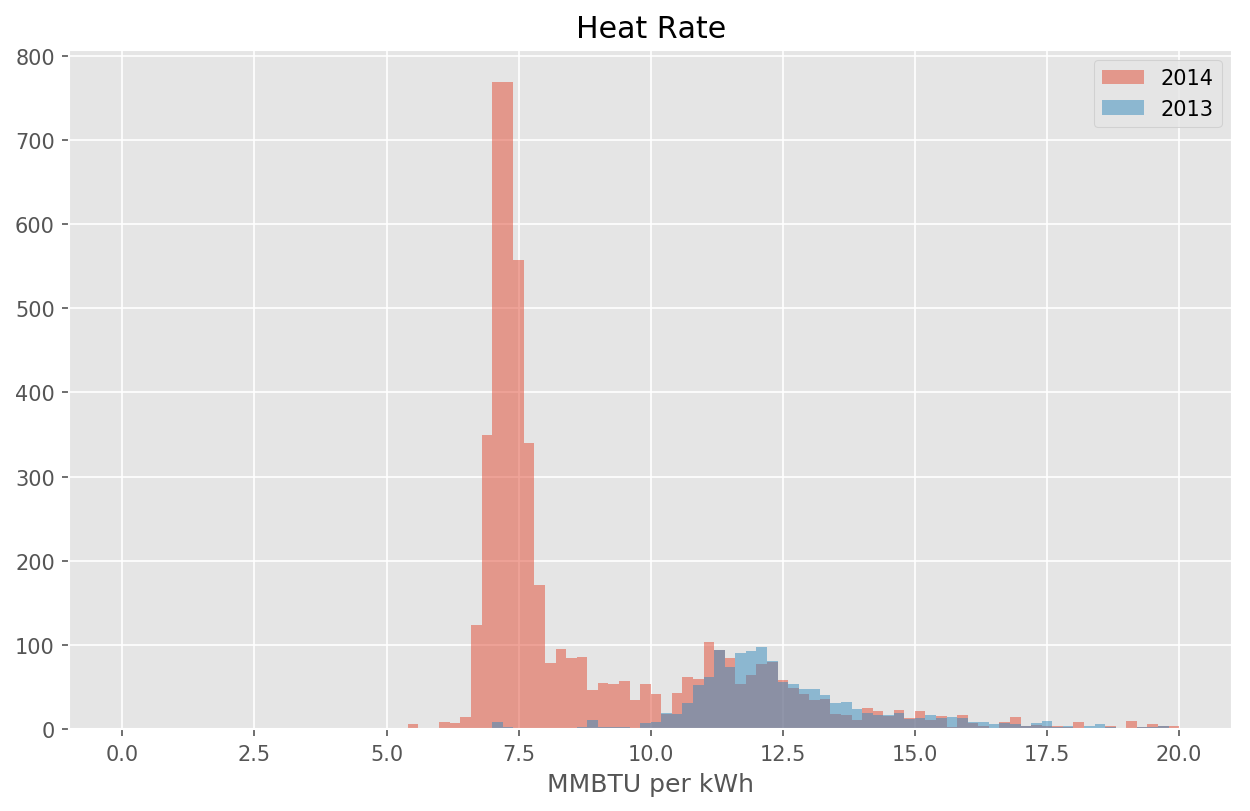

In [26]:
plt.hist(mcoe[(mcoe['energy_source_1'] == 'NG') & (mcoe['report_date'].dt.year == 2014)].heat_rate_mmbtu_mwh, range=[0,20],bins=100, alpha=0.5,label='2014')
plt.hist(mcoe[(mcoe['energy_source_1'] == 'NG') & (mcoe['report_date'].dt.year == 2013)].heat_rate_mmbtu_mwh, range=[0,20],bins=100, alpha=0.5,label='2013')
plt.xlabel('MMBTU per kWh')
plt.ylabel("")
plt.legend()
plt.title("Heat Rate")
plt.show()